In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import scipy.stats as stat
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings

In [2]:
#load data
house_df = pd.read_csv('data/house_mean_imputation.csv')
#house_df = pd.read_csv('data/house_model_imputation.csv')
house_df = house_df.drop_duplicates(['year', 'state', 'district', 'name'])
display(house_df.shape)
display(house_df.head())
display(house_df.describe())

(9974, 20)

,district,is_incumbent,name,party,percent,state,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_party,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,last_house_majority,fundraising
0,District 1,0.0,Ratliff Boon,D,42.1,Indiana,4281.0,1,1824,1824.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
1,District 1,1.0,Ratliff Boon,D,42.8,Indiana,5202.0,1,1826,1824.0,1,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
2,District 1,1.0,Ratliff Boon,D,52.2,Indiana,7272.0,1,1828,1824.0,2,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
3,District 1,0.0,John Law,D,49.1,Indiana,10868.0,0,1830,1860.0,0,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375
4,District 1,1.0,Ratliff Boon,D,50.9,Indiana,11280.0,1,1830,1824.0,3,5.790196,0.0,1.0,0,0.525667,200.179856,182.503597,D,552917.8375


,is_incumbent,percent,votes,won,year,first_time_elected,count_victories,unemployement_rate,is_presidential_year,president_can_be_re_elected,president_overall_avg_job_approval,last_D_house_seats,last_R_house_seats,fundraising
count,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9974.000000,9.974000e+03
mean,0.444456,50.968786,101123.196765,0.528474,1991.993884,1102.728093,0.963305,6.176784,0.481251,0.604071,0.493377,219.603971,210.664830,1.014975e+06
std,0.496930,19.917918,55100.387633,0.499214,31.278231,987.884433,1.826929,2.060743,0.499673,0.489074,0.062378,36.152015,34.645436,9.782140e+05
min,0.000000,0.000000,0.000000,0.000000,1824.000000,0.000000,0.000000,2.700000,0.000000,0.000000,0.395000,38.000000,86.000000,-3.469651e+04
25%,0.000000,36.160000,59347.250000,0.000000,1982.000000,0.000000,0.000000,4.600000,0.000000,0.000000,0.480000,194.000000,180.000000,5.015548e+05
50%,0.000000,50.235000,94682.000000,1.000000,2004.000000,1938.000000,0.000000,5.790931,0.000000,1.000000,0.490000,205.000000,225.000000,8.306668e+05
75%,1.000000,64.300000,136625.250000,1.000000,2012.000000,2002.000000,1.000000,7.000000,1.000000,1.000000,0.528000,248.000000,241.000000,1.329461e+06
max,1.000000,100.000000,322514.000000,1.000000,2018.000000,2018.000000,17.000000,19.000000,1.000000,1.000000,0.701000,334.000000,303.000000,3.410465e+07


In [3]:
#drop observations where president party is not defined
house_df=house_df.drop(house_df.loc[house_df['president_party']=="0"].index)

In [4]:
#baseline model
def winnerFilter(df):
    return df[df['won']==1][['state','district','party']].replace(['D', 'R'], [0, 1])

def baselineTrain(df):
    df_grouped=df[(df['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    df_grouped['R_occurence']=df_grouped['party'].str.count('R')/df_grouped['party'].str.len()
    df_grouped['party']=(df_grouped['R_occurence']>0.5).astype(int)
    df_grouped['proba']=(1-df_grouped['party']-df_grouped['R_occurence']).abs()
    return df_grouped[['state', 'district','party', 'proba']]

#prepare dataset indexed by state and district, with all results 
results=dict()
for year in house_df['year'].unique():
    results[year]=house_df[house_df['year']==year].groupby(['state', 'district']).count()
    results[year]=results[year].drop(columns = list(results[year]))    
    results[year]['partyWon']=winnerFilter(house_df[house_df['year']==year]).set_index(['state','district']).sort_index()
def districtPredictions(y_pred, year, partyWonCol='party', set_index=1):
    if set_index:
        df=results[year].join(y_pred.set_index(['state', 'district'])).sort_index().fillna(-1)
    else:
        df=results[year].join(y_pred).fillna(-1)
    return df
def districtAccuracy(y_pred, year, partyWonCol='party', set_index=1):
    df=districtPredictions(y_pred, year, partyWonCol, set_index)
    return sum(df['partyWon']==df[partyWonCol])/len(df)

In [5]:
y_pred=baselineTrain(house_df[house_df['year']!=2018]) #train simple average model, remove 2018 results
baseline_accuracy=districtAccuracy(y_pred, 2018)
print('Baseline accuracy: \t{:.2%}'.format(baseline_accuracy))

Baseline accuracy: 	76.78%


In [6]:
def splitDf(df, year):
    dfcopy=df.dropna().copy()
    indexed_districts=dfcopy[['state','district']]
    indexed_party=dfcopy[['party']].replace(['D', 'R'], [0, 1])
    dfcopy=dfcopy.drop('state', axis=1).drop('district', axis=1).drop('name', axis=1).drop('percent', axis=1).drop('votes', axis=1)
    data_train, data_test=dfcopy[dfcopy['year']!=year], dfcopy[dfcopy['year']==year]
    #data_train, data_test=dfcopy[dfcopy['year']<year], dfcopy[dfcopy['year']==year]

    x_train, y_train=data_train.drop('won', axis=1), data_train['won']
    x_test, y_test=data_test.drop('won', axis=1), data_test['won']
    return x_train, y_train, x_test, y_test, indexed_districts, indexed_party

In [7]:
#plot cross validation scores of decision trees
def plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title, xlabel='Depth'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(depths, scores_train, label = 'Full training set')
    ax.plot(depths, scores_train_CV, label = 'Cross validation means')
    upper=np.array(scores_train_CV)+2*np.array(scores_train_CVstd)
    lower=np.array(scores_train_CV)-2*np.array(scores_train_CVstd)
    ax.fill_between(depths, lower, upper, color='chocolate', alpha='0.1')
    ax.axhline(y=1, c='g', label='100% accuracy')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    #ax.set(ylim=([0.95*min(lower),1.05*max(upper)])) #I guess this is the meaning of "set the y-axis to focus on the cross-validation performance."
    ax.set_xticks(depths)
    ax.legend();
#plot scores of a model through years
def plotYearscores(years, scores_train, scores_train_CV, scores_CV_mutExcl, Accu_val_2_byDistrict, title, xlabel='Year'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(title, fontsize=24, y=1.0)
    ax.plot(years, scores_train, label = 'Full training set')
    ax.plot(years, scores_train_CV, label = 'CV mean score')
    ax.plot(years, scores_CV_mutExcl, label = 'CV mean mutually exclusive score')
    ax.plot(years, Accu_val_2_byDistrict, label = 'CV mean mutually exclusive score by district')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Score')
    ax.set_xticks(years)
    ax.legend();
#bar plot with model scores
def barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, scores_val_mut_escl_byDistrict, baseline_accuracy):
    #plot
    current_palette = sns.color_palette()
    fig, ax = plt.subplots(1, 1, figsize=(10, 1.5*len(models_names)))
    fig.suptitle('Scores of all fitted models on training vs cross-validation means', fontsize=24, y=1) 
    w=0.2
    a=np.arange(len(models_names))
    ax.barh(a+1.5*w, scores_train, height=w,align='center', color=current_palette[0], alpha=0.5, label='train set') 
    ax.barh(a+0.5*w, scores_val, height=w,align='center', color=current_palette[1], alpha=0.5, label='CV set')   
    ax.barh(a-0.5*w, scores_val_mut_escl, height=w,align='center', color=current_palette[2], alpha=0.5, label='CV set mut. excl.')  
    ax.barh(a-1.5*w, scores_val_mut_escl_byDistrict, height=w,align='center', color=current_palette[3], alpha=0.5, label='CV set mut. excl. by district')  
    
    for i, v in enumerate(scores_train):
        ax.text(v-0.025, i+1.5*w, '{:>.2%}'.format(v), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val[i]-0.025, i+0.5*w, '{:>.2%}'.format(scores_val[i]), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val_mut_escl[i]-0.025, i-0.5*w, '{:>.2%}'.format(scores_val_mut_escl[i]), color='white', fontsize=12, verticalalignment='center')
        ax.text(scores_val_mut_escl_byDistrict[i]-0.025, i-1.5*w, '{:>.2%}'.format(scores_val_mut_escl_byDistrict[i]), color='white', fontsize=12, verticalalignment='center')
  
    ax.axvline(x=baseline_accuracy, c='g', label='baseline')
    ax.text(baseline_accuracy, -1, '{:.2%}'.format(baseline_accuracy), color='green', horizontalalignment='center', verticalalignment='center', fontsize=12)
    ax.set_xlabel('Score')
    ax.set_yticklabels(models_names, fontdict=None, minor=False) 
    ax.set_yticks(a, minor=False)
    plt.xlim(baseline_accuracy*0.95,1)
    fig.legend(bbox_to_anchor=(1.35, 0.84));
def plotModelsScores(modelList, baseline_accuracy):
    models_names=[]
    scores_train=[] 
    scores_val=[] 
    scores_val_mut_escl=[]
    scores_stacking=[]
    scores_val_mut_escl_byDistrict=[]
    for model in modelList:
        models_names.append(model['name'])
        scores_train.append(model['score train'])
        scores_val.append(model['score validation'])
        scores_val_mut_escl.append(model['score val mut exclusive'])
        scores_val_mut_escl_byDistrict.append(model['score val mut exclusive by district']) 
    barplotScores(models_names, scores_train, scores_val, scores_val_mut_escl, scores_val_mut_escl_byDistrict, baseline_accuracy)

In [8]:
def deductPartisanship(trainData):
    #compute the prevalence of one party win against the other
    house_df_all_districts=trainData[(trainData['won']==1)].groupby(['state', 'district'])['party'].sum().reset_index(drop=False)
    house_df_all_districts['R_occurence']=house_df_all_districts['party'].str.count('R')/house_df_all_districts['party'].str.len()

    avgHistData=house_df_all_districts['party'].str.len().mean() #Average amount of historical data per district
    histDataThreshold=avgHistData/2

    #3=traditionally Republican district
    #2=traditionally Democratic district
    #1=swing district
    #0=Recent district (Not enough historical data)
    house_df_all_districts['partisanship']=(house_df_all_districts['party'].str.len()>=histDataThreshold)*(
                      (house_df_all_districts['R_occurence']>(2/3))*3
                    + (house_df_all_districts['R_occurence']<=(1/3))*2
                    + ((house_df_all_districts['R_occurence']>(1/3))
                      &(house_df_all_districts['R_occurence']<=(2/3)))*1
                    )
    house_df_all_districts['partisanship']=house_df_all_districts['partisanship'].astype(int)
    return house_df_all_districts[['state', 'district', 'partisanship']]

def assignPartisanship(x_train, y_train, indexed_districts, x_test):
    train_df=x_train.copy()
    train_df['won']=y_train
    train_df=indexed_districts.join(train_df).dropna()
    test_df=indexed_districts.join(x_test.copy()).dropna()

    out_df=test_df.join(deductPartisanship(train_df).set_index(['state', 'district']), on=['state', 'district']).drop('state', axis=1).drop('district', axis=1).fillna(0)
    out_df['partisanship']=out_df['partisanship'].astype(int)
    return out_df

In the `designFeatures` function we applied mathematical transformations, produced an amount of interaction terms, fixed a bug in the `first_time_elected` feature. 

To decide which columns to drop, we looked at the feature importance of the logistic regression model

In [9]:
def designFeatures(x_train, y_train, indexed_districts, df):
    df_out=df.copy()
    
    #first_time_elected relative to election year and non-negative
    df_out.loc[df_out['first_time_elected']>0, 'first_time_elected']=df_out['year']-df_out['first_time_elected']
    df_out.loc[df_out['first_time_elected']<0, 'first_time_elected']=0
    #df_out=df_out.drop('first_time_elected', axis=1)
    
    #Assign district partisanship
    df_out=assignPartisanship(x_train, y_train, indexed_districts, df_out)
    
    #calculate Log10 of fundraising
    df_out['Log10fundraising']=df_out['fundraising']
    df_out.loc[df_out['Log10fundraising']<=0, 'Log10fundraising']=np.NaN
    df_out['Log10fundraising']=np.log10(df_out['Log10fundraising']) #take the log10
    df_out.loc[df_out['Log10fundraising'].isna(), 'Log10fundraising']=0
    #drop linear fundraising
    df_out=df_out.drop('fundraising', axis=1)
    
    #president party is same party as candidate
    df_out['own_president_party']=(df_out['president_party']==df_out['party']).astype(int)
    df_out['own_last_house_majority']=(df_out['last_house_majority']==df_out['party']).astype(int)
    
    #replace 'D' and 'R' with 0 and 1 
    df_out['party']=df_out['party'].replace(['D', 'R'], [0, 1])
    df_out['president_party']=df_out['president_party'].replace(['D', 'R'], [0, 1])
    df_out['last_house_majority']=df_out['last_house_majority'].replace(['D', 'R'], [0, 1])
    
    #Is district partisan of the candidate's party?
    df_out['ownPartisan']=((df_out['partisanship'].astype(int))-df_out['party'].astype(int)==2).astype(int)
    df_out['swingDistrict']=(df_out['partisanship'].astype(int)==1).astype(int)
    #df_out=pd.get_dummies(df_out, columns=['partisanship'], drop_first=True)
    
    #Ratio of R vs D seats before election. Percentage of opponent seats in House 
    df_out['last_R_vs_D_Seats']=df_out['last_R_house_seats']/(df_out['last_R_house_seats']+df_out['last_D_house_seats']) #1=100% R, 0=100% D
    df_out=df_out.drop('last_R_house_seats', axis=1).drop('last_D_house_seats', axis=1)
    
    #Percentage of own party seats in House. Non-linear interaction term (because of abs)
    df_out['last_own_party_Seats']=(1-df_out['party']-df_out['last_R_vs_D_Seats']).abs() #1=100% own seats, 0=100% opponent
    
    #President job approval or opposition
    df_out['own_president_job_approval']=((df_out['own_president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    df_out['president_opposition_job_approval']=((df_out['party']-df_out['president_party']).abs()*df_out['president_overall_avg_job_approval']).abs()
    
    #Own president unemployment rate or opposition
    df_out['unemployement_rate_own_president']=df_out['own_president_party']*df_out['unemployement_rate']
    df_out['unemployement_rate_president_opposition']=(df_out['party']-df_out['president_party']).abs()*df_out['unemployement_rate']
    
    #drop party-related features
    #df_out=df_out.drop('year', axis=1)
    df_out=df_out.drop('last_R_vs_D_Seats', axis=1)
    df_out=df_out.drop('president_party', axis=1)
    df_out=df_out.drop('party', axis=1)
    df_out=df_out.drop('last_house_majority', axis=1)
    
    #drop multifactors features
    df_out=df_out.drop('partisanship', axis=1)
    
    #drop president-related features, without specification for candidates party
    df_out=df_out.drop('president_can_be_re_elected', axis=1)
    df_out=df_out.drop('president_overall_avg_job_approval', axis=1)
    
    #drop unnecessary features
    df_out=df_out.drop('is_presidential_year', axis=1)
    
    #drop collinear features
    #df_out=df_out.drop('unemployement_rate', axis=1)
    #df_out=df_out.drop('first_time_elected', axis=1)
    #df_out=df_out.drop('count_victories', axis=1)
    #df_out=df_out.drop('is_incumbent', axis=1)
    
    return df_out

In [10]:
def MutuallyExclusivePredictions(model, x_train, x_test, y_train, y_test, indexed_districts, indexed_party):
    #y_test is used only for accuracy score
    
    x_traincopy=x_train.copy()
    x_testcopy=x_test.copy()
    
    def Accuracy(y, y_pred):
        return np.sum(y == y_pred) / len(y)

    #predict results
    y_pred_train=model.predict(x_traincopy)
    y_pred_test=model.predict(x_testcopy)

    #calculate accuracy
    Accu_train=Accuracy(y_train, y_pred_train)
    Accu_val=Accuracy(y_test, y_pred_test)
    
    #At this stage, our predictions could lead to more than one winner per district (or none), but in reality they are mutually exclusive 
    #We will take the maximum prediction probabilities to be sure to have one and only one winner per district
    #predict probabilities
    y_pred_train=model.predict_proba(x_traincopy)[:,1]
    y_pred_test=model.predict_proba(x_testcopy)[:,1]

    #Add index to predictions from X set
    y_pred_train_df=pd.DataFrame(y_pred_train, index=x_traincopy.index, columns=['abs_won_proba'])
    y_pred_test_df=pd.DataFrame(y_pred_test, index=x_testcopy.index, columns=['abs_won_proba'])

    #Join party data to train and test datasets by index
    if 'party' not in list(x_traincopy):
        x_traincopy=indexed_party.join(x_traincopy).dropna()
        x_testcopy=indexed_party.join(x_testcopy).dropna()
   
    #Join district data, party and predictions by index
    districts_pred_train=indexed_districts.join(x_traincopy[['party']]).join(y_pred_train_df).dropna()
    districts_pred_test=indexed_districts.join(x_testcopy[['party']]).join(y_pred_test_df).dropna()

    #Group by district and aggregate predictions with max probability
    districts_pred_test_grouped=districts_pred_test.groupby(['state', 'district']).agg({'abs_won_proba':('max', 'sum')})
    districts_pred_test_grouped.columns = ['max_won_proba', 'sum_won_proba']
    districts_pred_test_grouped = districts_pred_test_grouped.reset_index(drop=False)

    #Create won_pred response variable (at this stage we have only the winner candidates)
    districts_pred_test_grouped['won_pred']=1

    #join district and party data with max predictions probabilities 
    out_df=districts_pred_test.join(districts_pred_test_grouped.set_index(['state', 'district', 'max_won_proba'])['won_pred'],on=['state', 'district', 'abs_won_proba']).fillna(0)

    #join district and party data with sum predictions probabilities 
    out_df=out_df.join(districts_pred_test_grouped.set_index(['state', 'district'])['sum_won_proba'],on=['state', 'district'])
    
    #calculate relative probability. That takes into account the predictions of the other candidates within the same district
    out_df['rel_won_proba']=out_df['abs_won_proba']/out_df['sum_won_proba']
    
    #check to have only and one only winner per district 
    districtWinners=out_df.groupby(['state', 'district'])['won_pred'].sum().reset_index(drop=False)
    NotJustOneWinner=districtWinners[districtWinners['won_pred']!=1]
    if (len(NotJustOneWinner)>0): 
        #display warning
        warnings.warn("\n{} districts have no winner or more than one winner.\nFollowing the list of affected districts:".format(len(NotJustOneWinner), DeprecationWarning))
        #print('List of affected districts:')
        display(districtWinners[districtWinners['won_pred']!=1])
        print('First occurrence from list:')
        display(out_df[(out_df['state']==NotJustOneWinner.iloc[0]['state'])&(out_df['district']==NotJustOneWinner.iloc[0]['district'])])
        districts_x_test=indexed_districts.join(x_testcopy).join(y_pred_test_df).dropna()
        print('Data of the occurrence from list:')
        display(districts_x_test[(districts_x_test['state']==NotJustOneWinner.iloc[0]['state'])&(districts_x_test['district']==NotJustOneWinner.iloc[0]['district'])])
        #manage conflicts: if more than one candidate have the same prediction probability, set all to zero
        #if they are all from the same party, though, set the first to one (we aim to predict party wins, not specific candidates)
        for state in NotJustOneWinner['state'].unique():
            for district in NotJustOneWinner[NotJustOneWinner['state']==state]['district'].unique():
                i=np.zeros(len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred'])) 
                if (len(out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'party'].unique())==1):
                    print('The conflict in {}, {} is between candidates from the same party, so we predict as winner in the district the first candidate of this party'.format(state, district))
                    i[0]=1
                out_df.loc[(out_df['state']==state)&(out_df['district']==district)&(out_df['won_pred']==1), 'won_pred']=i
                #display(out_df.loc[(out_df['state']==state)&(out_df['district']==district), 'won_pred'])
    #assert len(NotJustOneWinner) == 0, "{} districts have no winner or more than one winner".format(len(NotJustOneWinner))
    
    #validation accuracy score
    Accu_val_2=Accuracy(y_test, out_df['won_pred'])
    
    return Accu_train, Accu_val, Accu_val_2, out_df.drop('sum_won_proba', axis=1)

In [11]:
#pre-process of the data: split, design features, standardization
def pre_process(df, year):
    #split dataset
    x_train, y_train, x_test, y_test, df_districts, df_party = splitDf(df, year)

    #designFeatures
    x_train_designFeatures=designFeatures(x_train, y_train, df_districts, x_train)
    x_test_designFeatures=designFeatures(x_train, y_train, df_districts, x_test)

    #Standardize
    columns=list(x_train_designFeatures.select_dtypes(include='float'))
    #display(x_train_designFeatures.describe())
    scaler = StandardScaler().fit(x_train_designFeatures[columns])
    x_train_designFeatures.loc[:, columns]=scaler.transform(x_train_designFeatures[columns])
    x_test_designFeatures.loc[:, columns]=scaler.transform(x_test_designFeatures[columns])
            
    #remove columns which are not in both datasets, like set(dataset1)^set(dataset2)
    x_train_designFeatures=x_train_designFeatures[list(x_test_designFeatures)]
    
    return x_train_designFeatures, x_test_designFeatures, y_train, y_test, df_districts, df_party 

In [12]:
#train all models doing cross-validation through the years and store accuracy
def modelListTrain(modelList, train_df, years):
    train_data=train_df.copy()
    for i in range(len(modelList)):
        model=modelList[i]
        #intialize lists
        train_acc=[] #list with training accuracy
        val_acc=[] #list with validation accuracy
        val_acc_2=[] #list with mutually exclusive validation accuracy
        Accu_val_2_byDistrict=[] #list with mutually exclusive validation accuracy by district
        for year in years:
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))

            #pre_process
            x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party = pre_process(train_data, year)
            
            #fit model
            fitted_model=model['model'].fit(x_train_designFeatures, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party)

            #store accuracy
            train_acc.append(Accu_train)
            val_acc.append(Accu_val)
            val_acc_2.append(Accu_val_2)
            Accu_val_2_byDistrict.append(districtAccuracy(pred_df[pred_df['won_pred']==1], year))
            
            #print accuracy scores
            print('Training accuracy: {:.2%}\nValidation accuracy: {:.2%}\nMutually exclusive validation accuracy: {:.2%}\nMutually exclusive validation accuracy by district: {:.2%}\n'.format(train_acc[-1], val_acc[-1], val_acc_2[-1], Accu_val_2_byDistrict[-1]))
        #plot this model scores through years
        title='Scores of model {} cross-validated through years'.format(modelList[i]['name'])
        plotYearscores(years, train_acc, val_acc, val_acc_2, Accu_val_2_byDistrict, title, xlabel='Year')
        #store model scores into model list (mean of all years folds)
        modelList[i]['score train']=np.mean(train_acc)
        modelList[i]['score validation']=np.mean(val_acc)
        modelList[i]['score val mut exclusive']=np.mean(val_acc_2)
        modelList[i]['score val mut exclusive by district']=np.mean(Accu_val_2_byDistrict)
           
    display(modelList)

In [13]:
#training set on data starting from yearStart until before 2018, test set on 2018 data
yearStart=1918
train_data, test_data = house_df[(house_df['year']>=yearStart)&(house_df['year']!=2018)], house_df[house_df['year']==2018]

In [14]:
#Years lists for cross-validation folds
Midterm_recent_years=2014-4*np.arange(10)
display(Midterm_recent_years)

array([2014, 2010, 2006, 2002, 1998, 1994, 1990, 1986, 1982, 1978])

In [15]:
#define models to be trained
modelList=[]
#Logistic regression
model=dict()
model['name']='Logistic Regression CV=5'
model['model']=LogisticRegressionCV(cv=5, penalty='l2', max_iter=2500)
modelList.append(model)
#Logistic regression
#model=dict()
#model['name']='Logistic Regression CV=5, penalty=l1'
#model['model']=LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear', max_iter=2500)
#modelList.append(model)
#LDA
model=dict()
model['name']='LDA'
model['model']=LinearDiscriminantAnalysis(store_covariance=True)
modelList.append(model)
#Simple decision tree 
max_depth=4
model=dict()
model['name']='Decision Tree, depth={}'.format(max_depth)
model['model']=DecisionTreeClassifier(max_depth = max_depth)
modelList.append(model)
#Simple decision tree 
#max_depth=11
#model=dict()
#model['name']='Decision Tree, depth={}'.format(max_depth)
#model['model']=DecisionTreeClassifier(max_depth = max_depth)
#modelList.append(model)
#Random forest
max_depth=17
n_trees=100
model=dict()
model['name']='Random Forest of {} depth-{} trees'.format(n_trees, max_depth)
model['model']=RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth )
modelList.append(model)
#Boosting 
max_depth=1
n_trees=400
lrate=0.01
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_trees, learning_rate=lrate)
model=dict()
model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, max_depth)
model['model']=abc
modelList.append(model)  

years=Midterm_recent_years

model: Logistic Regression CV=5
year: 2014
Training accuracy: 88.35%
Validation accuracy: 89.12%
Mutually exclusive validation accuracy: 92.00%
Mutually exclusive validation accuracy by district: 92.79%

model: Logistic Regression CV=5
year: 2010
Training accuracy: 88.87%
Validation accuracy: 84.47%
Mutually exclusive validation accuracy: 82.95%
Mutually exclusive validation accuracy by district: 83.64%

model: Logistic Regression CV=5
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.076406,0.0,0.285621,0.267507
5538,Texas,District 22,1.0,0.104608,1.0,0.285621,0.366246
5539,Texas,District 22,1.0,0.104608,1.0,0.285621,0.366246


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.076406
5538,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.104608
5539,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.104608


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.71%
Validation accuracy: 89.32%
Mutually exclusive validation accuracy: 89.51%
Mutually exclusive validation accuracy by district: 90.07%

model: Logistic Regression CV=5
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.406571,1.0,1.219712,0.333333
4460,Louisiana,District 1,1.0,0.406571,1.0,1.219712,0.333333
4461,Louisiana,District 1,1.0,0.406571,1.0,1.219712,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.406571
4460,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.406571
4461,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.406571


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.81%
Validation accuracy: 84.92%
Mutually exclusive validation accuracy: 87.94%
Mutually exclusive validation accuracy by district: 89.70%

model: Logistic Regression CV=5
year: 1998
Training accuracy: 88.49%
Validation accuracy: 94.37%
Mutually exclusive validation accuracy: 95.67%
Mutually exclusive validation accuracy by district: 95.90%

model: Logistic Regression CV=5
year: 1994
Training accuracy: 88.56%
Validation accuracy: 88.62%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive valida

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.215003,1.0,0.628488,0.342095
2528,California,District 43,0.0,0.198483,0.0,0.628488,0.315809
2569,California,District 43,1.0,0.215003,1.0,0.628488,0.342095


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.215003
2528,California,District 43,0.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,0.0,1.0,0.0,1.0,0.740384,-0.983225,1.089515,-0.909358,2.080684,0.198483
2569,California,District 43,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.215003


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.74%
Validation accuracy: 87.50%
Mutually exclusive validation accuracy: 87.50%
Mutually exclusive validation accuracy by district: 89.55%

model: Logistic Regression CV=5
year: 1978
Training accuracy: 88.56%
Validation accuracy: 85.09%
Mutually exclusive validation accuracy: 87.72%
Mutually exclusive validation accuracy by district: 88.14%

model: LDA
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 86.27%
Validation accuracy: 90.50%
Mutually exclusive validation accuracy: 91.75%
Mutually exclusive validation accuracy by district: 92.56%

model: LDA
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 87.04%
Validation accuracy: 81.44%
Mutually exclusive validation accuracy: 82.95%
Mutually exclusive validation accuracy by district: 83.64%

model: LDA
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.015653,0.0,0.066326,0.235999
5538,Texas,District 22,1.0,0.025337,1.0,0.066326,0.382000
5539,Texas,District 22,1.0,0.025337,1.0,0.066326,0.382000


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.015653
5538,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.025337
5539,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.025337


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 86.60%
Validation accuracy: 87.96%
Mutually exclusive validation accuracy: 89.51%
Mutually exclusive validation accuracy by district: 90.07%

model: LDA
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.145514,1.0,0.436542,0.333333
4460,Louisiana,District 1,1.0,0.145514,1.0,0.436542,0.333333
4461,Louisiana,District 1,1.0,0.145514,1.0,0.436542,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.145514
4460,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.145514
4461,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.145514


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 87.41%
Validation accuracy: 72.85%
Mutually exclusive validation accuracy: 87.94%
Mutually exclusive validation accuracy by district: 89.70%

model: LDA
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 86.54%
Validation accuracy: 91.77%
Mutually exclusive validation accuracy: 95.67%
Mutually exclusive validation accuracy by district: 95.90%

model: LDA
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 86.66%
Validation accuracy: 87.43%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 89.53%

model: LDA
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 86.67%
Validation accuracy: 87.23%
Mutually exclusive validation accuracy: 91.49%
Mutually exclusive validation accuracy by district: 91.89%

model: LDA
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 86.62%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 93.94%
Mutually exclusive validation accuracy by district: 94.03%

model: LDA
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.076155,1.0,0.220791,0.344921
2528,California,District 43,0.0,0.068480,0.0,0.220791,0.310158
2569,California,District 43,1.0,0.076155,1.0,0.220791,0.344921


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.076155
2528,California,District 43,0.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,0.0,1.0,0.0,1.0,0.740384,-0.983225,1.089515,-0.909358,2.080684,0.068480
2569,California,District 43,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.076155


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 86.70%
Validation accuracy: 85.16%
Mutually exclusive validation accuracy: 87.50%
Mutually exclusive validation accuracy by district: 89.55%

model: LDA
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Training accuracy: 86.72%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 87.72%
Mutually exclusive validation accuracy by district: 88.14%

model: Decision Tree, depth=4
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
26 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
48,California,District 35,2.0
76,Colorado,District 4,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
199,Michigan,District 11,2.0
200,Michigan,District 12,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.185338,1.0,0.370675,0.5
8120,Arkansas,District 2,1.0,0.185338,1.0,0.370675,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,0.0,-0.906722,0.920833,-0.527395,-0.527574,-0.014864,0.431914,1.0,0.0,0.0,1.0,-0.464009,0.897453,-0.990406,0.905844,-0.916447,0.185338
8120,Arkansas,District 2,1.0,-0.906722,0.920833,-0.527395,-0.527574,-0.014864,0.213110,0.0,1.0,0.0,1.0,0.462083,-0.980862,0.888616,-0.907031,0.900347,0.185338


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.00%
Validation accuracy: 90.50%
Mutually exclusive validation accuracy: 92.62%
Mutually exclusive validation accuracy by district: 90.70%

model: Decision Tree, depth=4
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
15 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
176,Mississippi,District 4,2.0
198,New York,District 20,2.0
221,Ohio,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.206754,1.0,0.413508,0.5
6570,Alabama,District 5,0.0,0.206754,1.0,0.413508,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,1.0,-0.910866,0.703354,-0.520467,-0.521558,1.616394,0.216521,0.0,0.0,0.0,1.0,-1.166679,-0.984773,0.895170,-0.910711,1.857169,0.206754
6570,Alabama,District 5,0.0,-0.910866,0.703354,-0.520467,-0.521558,1.616394,0.256923,1.0,1.0,0.0,1.0,1.160748,0.897483,-0.987197,1.833295,-0.915551,0.206754


Training accuracy: 89.29%
Validation accuracy: 84.66%
Mutually exclusive validation accuracy: 84.66%
Mutually exclusive validation accuracy by district: 82.55%

model: Decision Tree, depth=4
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
7 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.149826,1.0,0.299652,0.5
5534,Arizona,District 8,1.0,0.149826,1.0,0.299652,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.651142,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.149826
5534,Arizona,District 8,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.651142,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.149826


Training accuracy: 89.15%
Validation accuracy: 89.32%
Mutually exclusive validation accuracy: 90.49%
Mutually exclusive validation accuracy by district: 89.71%

model: Decision Tree, depth=4
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
30 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.206107,1.0,0.412214,0.5
4512,Alabama,District 5,1.0,0.206107,1.0,0.412214,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,0.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,0.010507,0.0,0.0,0.0,1.0,-0.128731,-0.981790,0.951173,-0.904135,0.696940,0.206107
4512,Alabama,District 5,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,0.010507,1.0,1.0,0.0,1.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.206107


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 89.38%
Validation accuracy: 84.69%
Mutually exclusive validation accuracy: 88.17%
Mutually exclusive validation accuracy by district: 84.12%

model: Decision Tree, depth=4
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.224436,1.0,0.673307,0.333333
3719,California,District 1,1.0,0.224436,1.0,0.673307,0.333333
3720,California,District 1,1.0,0.224436,1.0,0.673307,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,1.0,0.0,0.0,1.0,-0.317693,1.189913,-0.989407,0.355811,-0.915841,0.224436
3719,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.224436
3720,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.224436


Training accuracy: 88.90%
Validation accuracy: 93.94%
Mutually exclusive validation accuracy: 96.54%
Mutually exclusive validation accuracy by district: 95.08%

model: Decision Tree, depth=4
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.2229,1.0,0.445799,0.5
3354,California,District 44,1.0,0.2229,1.0,0.445799,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,0.0,-0.910062,-0.021135,-0.529294,-0.529298,-0.30474,0.303174,1.0,1.0,0.0,1.0,1.202432,1.188558,-0.989663,0.729841,-0.913877,0.2229
3354,California,District 44,1.0,-0.910062,-0.021135,-0.529294,-0.529298,-0.30474,0.303174,0.0,0.0,0.0,1.0,-1.203432,-0.983381,1.182786,-0.906569,0.733614,0.2229


Training accuracy: 89.02%
Validation accuracy: 88.02%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 88.37%

model: Decision Tree, depth=4
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.221927,1.0,0.443854,0.5
3063,Colorado,District 4,1.0,0.221927,1.0,0.443854,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,0.0,-0.910327,-0.19567,-0.525369,-0.525884,-0.254966,0.380861,0.0,1.0,0.0,1.0,1.244054,-0.983945,1.416197,-0.906671,0.763036,0.221927
3063,Colorado,District 4,1.0,-0.910327,-0.19567,-0.525369,-0.525884,-0.254966,0.380861,1.0,0.0,0.0,1.0,-1.244474,1.421846,-0.990221,0.759067,-0.913965,0.221927


Training accuracy: 89.08%
Validation accuracy: 87.94%
Mutually exclusive validation accuracy: 90.07%
Mutually exclusive validation accuracy by district: 89.19%

model: Decision Tree, depth=4
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
54,Maryland,District 8,2.0
62,Utah,District 2,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.219766,1.0,0.439532,0.5
2736,California,District 12,0.0,0.219766,1.0,0.439532,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,1.0,-0.911609,-0.370308,-0.525543,-0.525904,0.28605,0.633095,1.0,0.0,0.0,1.0,-1.035376,1.095340,-0.989471,1.07451,-0.913531,0.219766
2736,California,District 12,0.0,-0.911609,-0.370308,-0.525543,-0.525904,0.28605,0.633095,0.0,1.0,0.0,1.0,1.035154,-0.983449,1.089818,-0.90644,1.080965,0.219766


Training accuracy: 89.11%
Validation accuracy: 90.15%
Mutually exclusive validation accuracy: 92.42%
Mutually exclusive validation accuracy by district: 88.06%

model: Decision Tree, depth=4
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0
40,California,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.219116,1.0,0.438231,0.5
2500,California,District 12,0.0,0.219116,1.0,0.438231,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,0.633468,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.219116
2500,California,District 12,0.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,0.633468,0.0,1.0,0.0,1.0,0.740384,-0.983225,1.089515,-0.909358,2.080684,0.219116


Training accuracy: 89.17%
Validation accuracy: 85.94%
Mutually exclusive validation accuracy: 90.62%
Mutually exclusive validation accuracy by district: 86.57%

model: Decision Tree, depth=4
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.220954,1.0,0.441907,0.5
2216,California,District 18,0.0,0.220954,1.0,0.441907,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,1.0,-0.91114,-0.720448,-0.527458,-0.527536,-0.3037,0.151315,0.0,0.0,0.0,1.0,-2.227951,-0.983377,0.798530,-0.906827,0.734804,0.220954
2216,California,District 18,0.0,-0.91114,-0.720448,-0.527458,-0.527536,-0.3037,0.151315,1.0,1.0,0.0,1.0,2.227225,0.804598,-0.989849,0.731218,-0.914313,0.220954


Training accuracy: 89.25%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 85.96%
Mutually exclusive validation accuracy by district: 83.05%

model: Random Forest of 100 depth-17 trees
year: 2014
Training accuracy: 97.72%
Validation accuracy: 90.25%
Mutually exclusive validation accuracy: 93.75%
Mutually exclusive validation accuracy by district: 94.42%

model: Random Forest of 100 depth-17 trees
year: 2010
Training accuracy: 97.61%
Validation accuracy: 81.82%
Mutually exclusive validation accuracy: 85.61%
Mutually exclusive validation accuracy by district: 86.18%

model: Random Forest of 100 depth-17 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.023893,0.0,0.344003,0.069457
5538,Texas,District 22,1.0,0.160055,1.0,0.344003,0.465272
5539,Texas,District 22,1.0,0.160055,1.0,0.344003,0.465272


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.023893
5538,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.160055
5539,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.160055


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 97.75%
Validation accuracy: 88.35%
Mutually exclusive validation accuracy: 89.90%
Mutually exclusive validation accuracy by district: 90.44%

model: Random Forest of 100 depth-17 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.644087,1.0,1.932262,0.333333
4460,Louisiana,District 1,1.0,0.644087,1.0,1.932262,0.333333
4461,Louisiana,District 1,1.0,0.644087,1.0,1.932262,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.644087
4460,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.644087
4461,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.644087


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 97.72%
Validation accuracy: 85.15%
Mutually exclusive validation accuracy: 88.40%
Mutually exclusive validation accuracy by district: 90.13%

model: Random Forest of 100 depth-17 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.086061,0.0,0.338635,0.25414
3719,California,District 1,1.0,0.126287,1.0,0.338635,0.37293
3720,California,District 1,1.0,0.126287,1.0,0.338635,0.37293


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,1.0,0.0,0.0,1.0,-0.317693,1.189913,-0.989407,0.355811,-0.915841,0.086061
3719,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.126287
3720,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.126287


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 97.60%
Validation accuracy: 94.81%
Mutually exclusive validation accuracy: 97.40%
Mutually exclusive validation accuracy by district: 97.54%

model: Random Forest of 100 depth-17 trees
year: 1994
Training accuracy: 97.75%
Validation accuracy: 89.22%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 89.53%

model: Random Forest of 100 depth-17 trees
year: 1990
Training accuracy: 97.83%
Validation accuracy: 85.82%
Mutually exclusive validation accuracy: 88.65%
Mutually exclusive validation accuracy by district: 89.19%

model: Random Forest of 100 depth-17 trees
year: 1986
Training accuracy: 97.54%
Validation accuracy: 90.91%
Mutually exclusive validation accuracy: 95.45%
Mutually exclusive validation accuracy by district: 95.52%

model: Random Forest of 100 depth-17 t

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
19 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0
199,Michigan,District 11,2.0
208,Michigan,District 8,2.0
240,New Jersey,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.403786,1.0,0.807572,0.5
8120,Arkansas,District 2,1.0,0.403786,1.0,0.807572,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,0.0,-0.906722,0.920833,-0.527395,-0.527574,-0.014864,0.431914,1.0,0.0,0.0,1.0,-0.464009,0.897453,-0.990406,0.905844,-0.916447,0.403786
8120,Arkansas,District 2,1.0,-0.906722,0.920833,-0.527395,-0.527574,-0.014864,0.213110,0.0,1.0,0.0,1.0,0.462083,-0.980862,0.888616,-0.907031,0.900347,0.403786


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 88.15%
Validation accuracy: 90.50%
Mutually exclusive validation accuracy: 93.12%
Mutually exclusive validation accuracy by district: 91.63%

model: AdaBoost Classifier 400 depth-1 trees
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
9 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
221,Ohio,District 2,2.0
270,Virginia,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.402854,1.0,0.805707,0.5
6570,Alabama,District 5,0.0,0.402854,1.0,0.805707,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,1.0,-0.910866,0.703354,-0.520467,-0.521558,1.616394,0.216521,0.0,0.0,0.0,1.0,-1.166679,-0.984773,0.895170,-0.910711,1.857169,0.402854
6570,Alabama,District 5,0.0,-0.910866,0.703354,-0.520467,-0.521558,1.616394,0.256923,1.0,1.0,0.0,1.0,1.160748,0.897483,-0.987197,1.833295,-0.915551,0.402854


Training accuracy: 87.11%
Validation accuracy: 81.63%
Mutually exclusive validation accuracy: 84.66%
Mutually exclusive validation accuracy by district: 83.64%

model: AdaBoost Classifier 400 depth-1 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
7 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.404821,1.0,0.809642,0.5
5534,Arizona,District 8,1.0,0.404821,1.0,0.809642,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.651142,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.404821
5534,Arizona,District 8,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.651142,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.404821


Training accuracy: 88.52%
Validation accuracy: 88.74%
Mutually exclusive validation accuracy: 90.49%
Mutually exclusive validation accuracy by district: 89.71%

model: AdaBoost Classifier 400 depth-1 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
30 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.402679,1.0,0.805358,0.5
4512,Alabama,District 5,1.0,0.402679,1.0,0.805358,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,0.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,0.010507,0.0,0.0,0.0,1.0,-0.128731,-0.981790,0.951173,-0.904135,0.696940,0.402679
4512,Alabama,District 5,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,0.010507,1.0,1.0,0.0,1.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.402679


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
Training accuracy: 87.50%
Validation accuracy: 72.85%
Mutually exclusive validation accuracy: 88.17%
Mutually exclusive validation accuracy by district: 84.12%

model: AdaBoost Classifier 400 depth-1 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.406723,1.0,1.22017,0.333333
3719,California,District 1,1.0,0.406723,1.0,1.22017,0.333333
3720,California,District 1,1.0,0.406723,1.0,1.22017,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,1.0,0.0,0.0,1.0,-0.317693,1.189913,-0.989407,0.355811,-0.915841,0.406723
3719,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.406723
3720,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.406723


Training accuracy: 88.25%
Validation accuracy: 94.37%
Mutually exclusive validation accuracy: 96.54%
Mutually exclusive validation accuracy by district: 95.08%

model: AdaBoost Classifier 400 depth-1 trees
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.406027,1.0,0.812055,0.5
3354,California,District 44,1.0,0.406027,1.0,0.812055,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,0.0,-0.910062,-0.021135,-0.529294,-0.529298,-0.30474,0.303174,1.0,1.0,0.0,1.0,1.202432,1.188558,-0.989663,0.729841,-0.913877,0.406027
3354,California,District 44,1.0,-0.910062,-0.021135,-0.529294,-0.529298,-0.30474,0.303174,0.0,0.0,0.0,1.0,-1.203432,-0.983381,1.182786,-0.906569,0.733614,0.406027


Training accuracy: 88.20%
Validation accuracy: 88.62%
Mutually exclusive validation accuracy: 89.22%
Mutually exclusive validation accuracy by district: 88.37%

model: AdaBoost Classifier 400 depth-1 trees
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.406165,1.0,0.81233,0.5
3063,Colorado,District 4,1.0,0.406165,1.0,0.81233,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,0.0,-0.910327,-0.19567,-0.525369,-0.525884,-0.254966,0.380861,0.0,1.0,0.0,1.0,1.244054,-0.983945,1.416197,-0.906671,0.763036,0.406165
3063,Colorado,District 4,1.0,-0.910327,-0.19567,-0.525369,-0.525884,-0.254966,0.380861,1.0,0.0,0.0,1.0,-1.244474,1.421846,-0.990221,0.759067,-0.913965,0.406165


Training accuracy: 88.30%
Validation accuracy: 89.36%
Mutually exclusive validation accuracy: 90.07%
Mutually exclusive validation accuracy by district: 89.19%

model: AdaBoost Classifier 400 depth-1 trees
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
54,Maryland,District 8,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.406268,1.0,0.812536,0.5
2736,California,District 12,0.0,0.406268,1.0,0.812536,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,1.0,-0.911609,-0.370308,-0.525543,-0.525904,0.28605,0.633095,1.0,0.0,0.0,1.0,-1.035376,1.095340,-0.989471,1.07451,-0.913531,0.406268
2736,California,District 12,0.0,-0.911609,-0.370308,-0.525543,-0.525904,0.28605,0.633095,0.0,1.0,0.0,1.0,1.035154,-0.983449,1.089818,-0.90644,1.080965,0.406268


Training accuracy: 88.52%
Validation accuracy: 87.88%
Mutually exclusive validation accuracy: 93.18%
Mutually exclusive validation accuracy by district: 89.55%

model: AdaBoost Classifier 400 depth-1 trees
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0
40,California,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.40589,1.0,0.811781,0.5
2500,California,District 12,0.0,0.40589,1.0,0.811781,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,0.633468,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.40589
2500,California,District 12,0.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,0.633468,0.0,1.0,0.0,1.0,0.740384,-0.983225,1.089515,-0.909358,2.080684,0.40589


Training accuracy: 88.53%
Validation accuracy: 87.50%
Mutually exclusive validation accuracy: 90.62%
Mutually exclusive validation accuracy by district: 86.57%

model: AdaBoost Classifier 400 depth-1 trees
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.405583,1.0,0.811167,0.5
2216,California,District 18,0.0,0.405583,1.0,0.811167,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,1.0,-0.91114,-0.720448,-0.527458,-0.527536,-0.3037,0.151315,0.0,0.0,0.0,1.0,-2.227951,-0.983377,0.798530,-0.906827,0.734804,0.405583
2216,California,District 18,0.0,-0.91114,-0.720448,-0.527458,-0.527536,-0.3037,0.151315,1.0,1.0,0.0,1.0,2.227225,0.804598,-0.989849,0.731218,-0.914313,0.405583


Training accuracy: 88.49%
Validation accuracy: 83.33%
Mutually exclusive validation accuracy: 85.96%
Mutually exclusive validation accuracy by district: 83.05%



[{'name': 'Logistic Regression CV=5',
  'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
             fit_intercept=True, intercept_scaling=1.0, max_iter=2500,
             multi_class='warn', n_jobs=None, penalty='l2',
             random_state=None, refit=True, scoring=None, solver='lbfgs',
             tol=0.0001, verbose=0),
  'score train': 0.886511228757505,
  'score validation': 0.8792870531738048,
  'score val mut exclusive': 0.8994599013236362,
  'score val mut exclusive by district': 0.9067387965810927},
 {'name': 'LDA',
  'model': LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                solver='svd', store_covariance=True, tol=0.0001),
  'score train': 0.8672331384354394,
  'score validation': 0.8578295698077326,
  'score val mut exclusive': 0.8976947498084847,
  'score val mut exclusive by district': 0.905013701128125},
 {'name': 'Decision Tree, depth=4',
  'model': DecisionTreeClassifier(class_weight=None, criterio

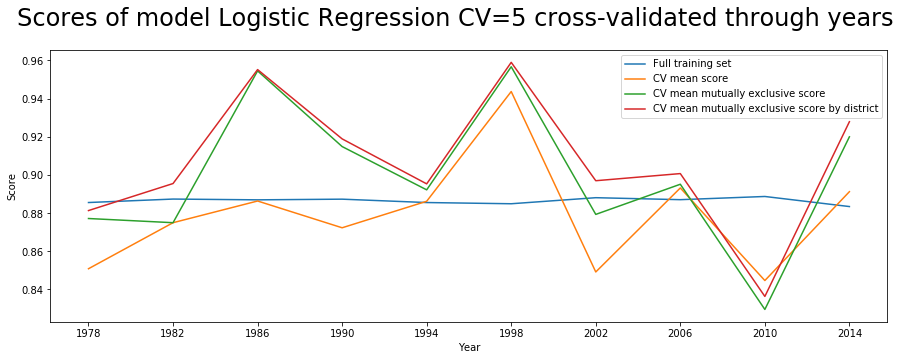

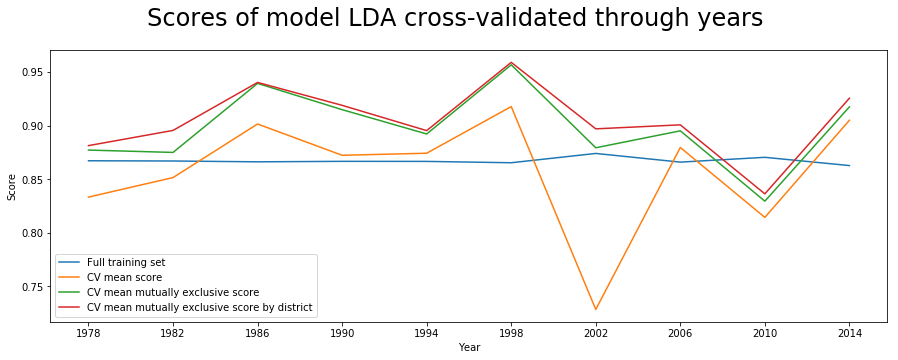

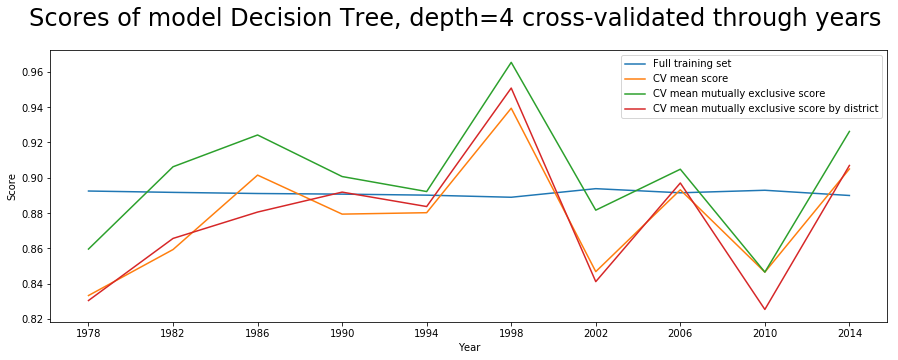

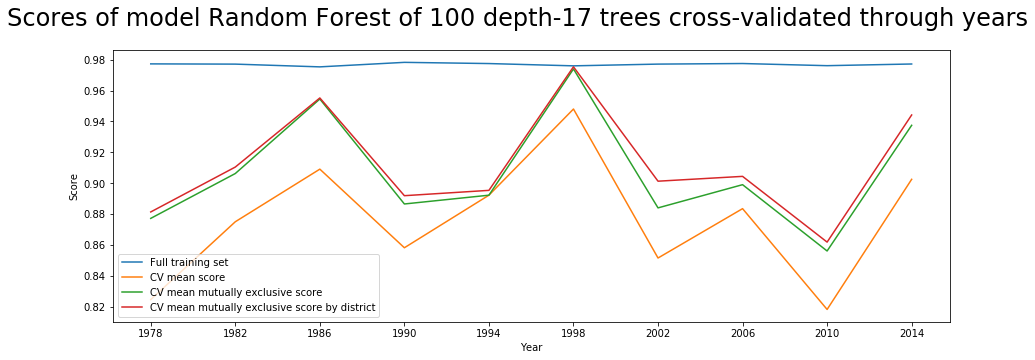

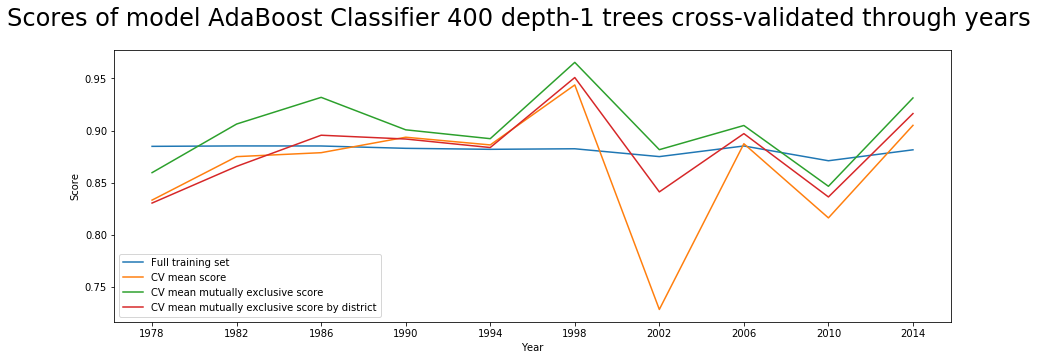

In [16]:
#train models using cross-validation through the years and calculate accuracies
modelListTrain(modelList, train_data, years)

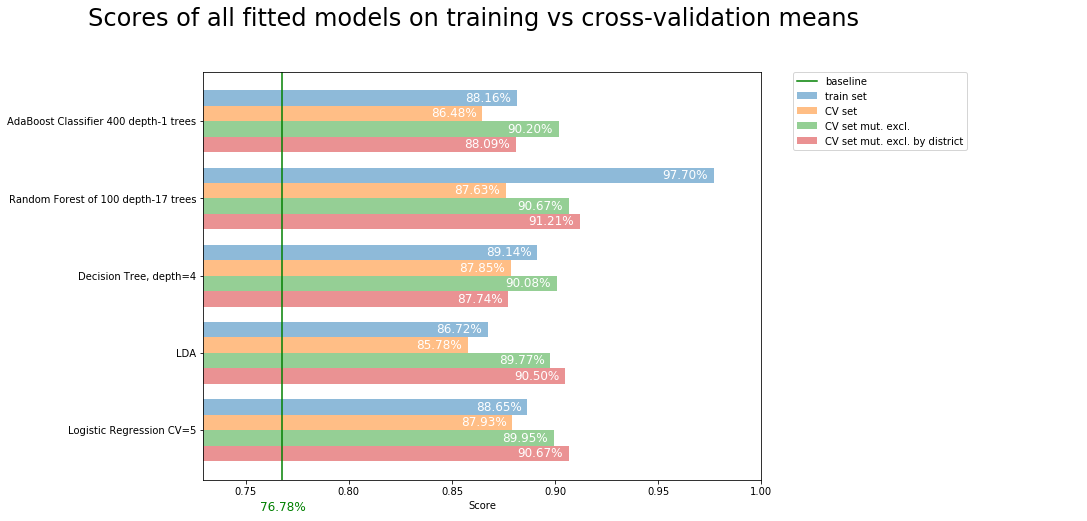

In [17]:
plotModelsScores(modelList, baseline_accuracy)

We notice how the single best performing model is random forest, with depth=17 and 100 iterations 

The mean score over the validation folds is improved by the mutually exclusive function. This score is still relative to the single candidates.

Then we extract only the predicted winners in each district and we compare them with the party of real winners. That is the validation set mutually excusive by district. 

The latter score is what we aim to optimize, as our purpose is to predict the winning party in each district.

Let's now try to improve this using stacking

In [18]:
def featureImportance(x, y):
    scores, pvalues = chi2(x, y)
    featureImportance=pd.DataFrame([list(x), list(pvalues)]).T
    featureImportance.columns=['coeff', 'p-value']
    featureImportance=featureImportance.set_index('coeff')
    display(featureImportance)

To do stacking, we will store the predictions of a list of models, one column per model and its probability

We will predict results for a list of years (excluding 2018), using the other years data as training. 

Then we will use this data to fit the stacking linear model

In [19]:
#Stacking all models
def predictForStack(df, years, modelList):
    train_data=df.copy()
    stackCols=['state', 'district', 'baseline', 'baseline_proba']
    for i in range(len(modelList)):
        stackCols.append('pred_{}'.format(i))
        stackCols.append('proba_{}'.format(i))
    stackCols.append('party')
    predictionsToStack=pd.DataFrame(columns=stackCols)
    for year in years:        
        #pre_process
        x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party = pre_process(train_data, year)

        #baseline model predictions
        y_pred=baselineTrain(train_data[train_data['year']!=year]).set_index(['state', 'district']).sort_index().astype(float) #train simple average model, remove 2018 results
        y_pred=y_pred.rename(index=str, columns={'party': 'baseline', 'proba': 'baseline_proba'})

        for i, model in enumerate(modelList):
            print('model: {}'.format(model['name']))
            print('year: {}'.format(year))
            #fit model
            fitted_model=model['model'].fit(x_train_designFeatures, y_train)

            #generate predictions and calculate accuracy
            Accu_train, Accu_val, Accu_val_2, pred_df = MutuallyExclusivePredictions(fitted_model, x_train_designFeatures, x_test_designFeatures, y_train, y_test, house_df_districts, house_df_party)

            #predictions by district and winning party only
            y_pred_i=pred_df[pred_df['won_pred']==1].set_index(['state', 'district']).sort_index()
            y_pred_i['proba_{}'.format(i)]=y_pred_i['rel_won_proba']
            y_pred_i=y_pred_i.drop(columns=['abs_won_proba', 'won_pred', 'rel_won_proba'])
            y_pred_i=y_pred_i.rename(index=str, columns={'party': 'pred_{}'.format(i)})

            #Add column with current model predictions
            y_pred = pd.concat([y_pred, y_pred_i], axis=1).fillna(-1)
            y_pred['proba_{}'.format(i)]=y_pred['proba_{}'.format(i)].replace(-1,0)
        y_pred['baseline_proba']=y_pred['baseline_proba'].replace(-1,0)
        #Add last column with actual results
        y_val=winnerFilter(train_data[train_data['year']==year]).set_index(['state', 'district']).sort_index() #extract winner party for each district in 2018
        y_pred=y_pred.join(y_val).dropna()

        #Append all models predictions for current year to the other years' predictions
        predictionsToStack=predictionsToStack.append(y_pred.reset_index(drop=False)[stackCols])  
    #if asking only for one year, return predictions by state and district, without actual results (it means it's for 2018)
    if (len(years)==1): 
        return predictionsToStack.drop('party', axis=1).set_index(['state', 'district']).sort_index()
    #if asking for several years, predictions and actual results will be used to fit a stacking model, so remove state, district index and include actual results
    return predictionsToStack.drop(columns=['state', 'district'])

First we generate the predictions for all available models:

In [20]:
#Generate predictions for stacking
predictionsToStack=predictForStack(train_data, years, modelList)

model: Logistic Regression CV=5
year: 2014
model: LDA
year: 2014
model: Decision Tree, depth=4
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
26 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
48,California,District 35,2.0
76,Colorado,District 4,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
199,Michigan,District 11,2.0
200,Michigan,District 12,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.185338,1.0,0.370675,0.5
8120,Arkansas,District 2,1.0,0.185338,1.0,0.370675,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,0.0,-0.906722,0.920833,-0.527395,-0.527574,-0.014864,0.431914,1.0,0.0,0.0,1.0,-0.464009,0.897453,-0.990406,0.905844,-0.916447,0.185338
8120,Arkansas,District 2,1.0,-0.906722,0.920833,-0.527395,-0.527574,-0.014864,0.213110,0.0,1.0,0.0,1.0,0.462083,-0.980862,0.888616,-0.907031,0.900347,0.185338


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in California, District 35 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Random Forest of 100 depth-17 trees
year: 2014
model: AdaBoost Classifier 400 depth-1 trees
year: 2014


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
19 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
17,Arkansas,District 2,2.0
22,California,District 11,2.0
37,California,District 25,2.0
46,California,District 33,2.0
158,Iowa,District 1,2.0
179,Maine,District 2,2.0
193,Massachusetts,District 6,2.0
199,Michigan,District 11,2.0
208,Michigan,District 8,2.0
240,New Jersey,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
8114,Arkansas,District 2,0.0,0.403786,1.0,0.807572,0.5
8120,Arkansas,District 2,1.0,0.403786,1.0,0.807572,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
8114,Arkansas,District 2,0.0,-0.906722,0.920833,-0.527395,-0.527574,-0.014864,0.431914,1.0,0.0,0.0,1.0,-0.464009,0.897453,-0.990406,0.905844,-0.916447,0.403786
8120,Arkansas,District 2,1.0,-0.906722,0.920833,-0.527395,-0.527574,-0.014864,0.213110,0.0,1.0,0.0,1.0,0.462083,-0.980862,0.888616,-0.907031,0.900347,0.403786


The conflict in California, District 25 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Washington, District 4 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Logistic Regression CV=5
year: 2010
model: LDA
year: 2010
model: Decision Tree, depth=4
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
15 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
176,Mississippi,District 4,2.0
198,New York,District 20,2.0
221,Ohio,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.206754,1.0,0.413508,0.5
6570,Alabama,District 5,0.0,0.206754,1.0,0.413508,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,1.0,-0.910866,0.703354,-0.520467,-0.521558,1.616394,0.216521,0.0,0.0,0.0,1.0,-1.166679,-0.984773,0.895170,-0.910711,1.857169,0.206754
6570,Alabama,District 5,0.0,-0.910866,0.703354,-0.520467,-0.521558,1.616394,0.256923,1.0,1.0,0.0,1.0,1.160748,0.897483,-0.987197,1.833295,-0.915551,0.206754


model: Random Forest of 100 depth-17 trees
year: 2010
model: AdaBoost Classifier 400 depth-1 trees
year: 2010


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
9 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
10,Arizona,District 3,2.0
16,Arkansas,District 1,2.0
17,Arkansas,District 2,2.0
84,Delaware,At-Large,2.0
142,Kansas,District 3,2.0
152,Louisiana,District 3,2.0
221,Ohio,District 2,2.0
270,Virginia,District 5,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
6569,Alabama,District 5,1.0,0.402854,1.0,0.805707,0.5
6570,Alabama,District 5,0.0,0.402854,1.0,0.805707,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
6569,Alabama,District 5,1.0,-0.910866,0.703354,-0.520467,-0.521558,1.616394,0.216521,0.0,0.0,0.0,1.0,-1.166679,-0.984773,0.895170,-0.910711,1.857169,0.402854
6570,Alabama,District 5,0.0,-0.910866,0.703354,-0.520467,-0.521558,1.616394,0.256923,1.0,1.0,0.0,1.0,1.160748,0.897483,-0.987197,1.833295,-0.915551,0.402854


model: Logistic Regression CV=5
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.076406,0.0,0.285621,0.267507
5538,Texas,District 22,1.0,0.104608,1.0,0.285621,0.366246
5539,Texas,District 22,1.0,0.104608,1.0,0.285621,0.366246


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.076406
5538,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.104608
5539,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.104608


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 2006


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.015653,0.0,0.066326,0.235999
5538,Texas,District 22,1.0,0.025337,1.0,0.066326,0.382000
5539,Texas,District 22,1.0,0.025337,1.0,0.066326,0.382000


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.015653
5538,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.025337
5539,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.025337


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
7 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.149826,1.0,0.299652,0.5
5534,Arizona,District 8,1.0,0.149826,1.0,0.299652,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.651142,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.149826
5534,Arizona,District 8,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.651142,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.149826


model: Random Forest of 100 depth-17 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
247,Texas,District 22,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5537,Texas,District 22,0.0,0.038756,0.0,0.388352,0.099795
5538,Texas,District 22,1.0,0.174798,1.0,0.388352,0.450102
5539,Texas,District 22,1.0,0.174798,1.0,0.388352,0.450102


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5537,Texas,District 22,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.038756
5538,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.174798
5539,Texas,District 22,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.153827,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.174798


The conflict in Texas, District 22 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 2006


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
7 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
15,Arizona,District 8,2.0
86,Florida,District 11,2.0
108,Florida,District 9,2.0
137,Iowa,District 1,2.0
245,Texas,District 20,2.0
247,Texas,District 22,3.0
265,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
5533,Arizona,District 8,0.0,0.404821,1.0,0.809642,0.5
5534,Arizona,District 8,1.0,0.404821,1.0,0.809642,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
5533,Arizona,District 8,0.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.651142,0.0,0.0,0.0,0.0,-0.428942,-0.985251,0.954219,-0.912827,0.316739,0.404821
5534,Arizona,District 8,1.0,-0.908397,0.517988,-0.520727,-0.520975,-1.047771,0.651142,1.0,1.0,0.0,0.0,0.425791,0.955123,-0.986445,0.312808,-0.916085,0.404821


model: Logistic Regression CV=5
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.406571,1.0,1.219712,0.333333
4460,Louisiana,District 1,1.0,0.406571,1.0,1.219712,0.333333
4461,Louisiana,District 1,1.0,0.406571,1.0,1.219712,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.406571
4460,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.406571
4461,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.406571


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.145514,1.0,0.436542,0.333333
4460,Louisiana,District 1,1.0,0.145514,1.0,0.436542,0.333333
4461,Louisiana,District 1,1.0,0.145514,1.0,0.436542,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.145514
4460,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.145514
4461,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.145514


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
30 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.206107,1.0,0.412214,0.5
4512,Alabama,District 5,1.0,0.206107,1.0,0.412214,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,0.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,0.010507,0.0,0.0,0.0,1.0,-0.128731,-0.981790,0.951173,-0.904135,0.696940,0.206107
4512,Alabama,District 5,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,0.010507,1.0,1.0,0.0,1.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.206107


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Random Forest of 100 depth-17 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
3 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
144,Louisiana,District 1,3.0
145,Louisiana,District 2,3.0
179,New Mexico,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4458,Louisiana,District 1,1.0,0.636833,1.0,1.9105,0.333333
4460,Louisiana,District 1,1.0,0.636833,1.0,1.9105,0.333333
4461,Louisiana,District 1,1.0,0.636833,1.0,1.9105,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4458,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.636833
4460,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.636833
4461,Louisiana,District 1,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,-1.987669,1.0,1.0,1.0,0.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.636833


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 2002


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
30 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
4,Alabama,District 5,2.0
7,Arizona,District 1,2.0
9,Arizona,District 3,2.0
10,Arizona,District 4,2.0
14,Arizona,District 8,2.0
15,Arkansas,District 1,2.0
18,Arkansas,District 4,2.0
28,California,District 18,2.0
32,California,District 21,2.0
74,Colorado,District 4,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
4511,Alabama,District 5,0.0,0.402679,1.0,0.805358,0.5
4512,Alabama,District 5,1.0,0.402679,1.0,0.805358,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
4511,Alabama,District 5,0.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,0.010507,0.0,0.0,0.0,1.0,-0.128731,-0.981790,0.951173,-0.904135,0.696940,0.402679
4512,Alabama,District 5,1.0,-0.927835,0.334603,-0.534489,-0.534076,-0.360534,0.010507,1.0,1.0,0.0,1.0,0.128234,0.959077,-0.990194,0.694796,-0.913316,0.402679


The conflict in Louisiana, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in Louisiana, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
The conflict in New Mexico, District 2 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Logistic Regression CV=5
year: 1998
model: LDA
year: 1998
model: Decision Tree, depth=4
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.224436,1.0,0.673307,0.333333
3719,California,District 1,1.0,0.224436,1.0,0.673307,0.333333
3720,California,District 1,1.0,0.224436,1.0,0.673307,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,1.0,0.0,0.0,1.0,-0.317693,1.189913,-0.989407,0.355811,-0.915841,0.224436
3719,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.224436
3720,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.224436


model: Random Forest of 100 depth-17 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.065708,0.0,0.223524,0.293964
3719,California,District 1,1.0,0.078908,1.0,0.223524,0.353018
3720,California,District 1,1.0,0.078908,1.0,0.223524,0.353018


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,1.0,0.0,0.0,1.0,-0.317693,1.189913,-0.989407,0.355811,-0.915841,0.065708
3719,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.078908
3720,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.078908


The conflict in California, District 1 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: AdaBoost Classifier 400 depth-1 trees
year: 1998


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
0,California,District 1,3.0
83,New York,District 13,2.0
92,New York,District 22,2.0
97,New York,District 27,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3714,California,District 1,0.0,0.406723,1.0,1.22017,0.333333
3719,California,District 1,1.0,0.406723,1.0,1.22017,0.333333
3720,California,District 1,1.0,0.406723,1.0,1.22017,0.333333


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3714,California,District 1,0.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,1.0,0.0,0.0,1.0,-0.317693,1.189913,-0.989407,0.355811,-0.915841,0.406723
3719,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.406723
3720,California,District 1,1.0,-0.910718,0.154275,-0.527434,-0.527,-0.959874,0.097687,0.0,1.0,0.0,1.0,0.317211,-0.983544,1.184668,-0.908867,0.357270,0.406723


model: Logistic Regression CV=5
year: 1994
model: LDA
year: 1994
model: Decision Tree, depth=4
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.2229,1.0,0.445799,0.5
3354,California,District 44,1.0,0.2229,1.0,0.445799,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,0.0,-0.910062,-0.021135,-0.529294,-0.529298,-0.30474,0.303174,1.0,1.0,0.0,1.0,1.202432,1.188558,-0.989663,0.729841,-0.913877,0.2229
3354,California,District 44,1.0,-0.910062,-0.021135,-0.529294,-0.529298,-0.30474,0.303174,0.0,0.0,0.0,1.0,-1.203432,-0.983381,1.182786,-0.906569,0.733614,0.2229


model: Random Forest of 100 depth-17 trees
year: 1994
model: AdaBoost Classifier 400 depth-1 trees
year: 1994


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
37,California,District 44,2.0
64,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3294,California,District 44,0.0,0.406027,1.0,0.812055,0.5
3354,California,District 44,1.0,0.406027,1.0,0.812055,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3294,California,District 44,0.0,-0.910062,-0.021135,-0.529294,-0.529298,-0.30474,0.303174,1.0,1.0,0.0,1.0,1.202432,1.188558,-0.989663,0.729841,-0.913877,0.406027
3354,California,District 44,1.0,-0.910062,-0.021135,-0.529294,-0.529298,-0.30474,0.303174,0.0,0.0,0.0,1.0,-1.203432,-0.983381,1.182786,-0.906569,0.733614,0.406027


model: Logistic Regression CV=5
year: 1990
model: LDA
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


model: Decision Tree, depth=4
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.221927,1.0,0.443854,0.5
3063,Colorado,District 4,1.0,0.221927,1.0,0.443854,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,0.0,-0.910327,-0.19567,-0.525369,-0.525884,-0.254966,0.380861,0.0,1.0,0.0,1.0,1.244054,-0.983945,1.416197,-0.906671,0.763036,0.221927
3063,Colorado,District 4,1.0,-0.910327,-0.19567,-0.525369,-0.525884,-0.254966,0.380861,1.0,0.0,0.0,1.0,-1.244474,1.421846,-0.990221,0.759067,-0.913965,0.221927


model: Random Forest of 100 depth-17 trees
year: 1990
model: AdaBoost Classifier 400 depth-1 trees
year: 1990


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
2 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
45,Colorado,District 4,2.0
70,Vermont,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
3062,Colorado,District 4,0.0,0.406165,1.0,0.81233,0.5
3063,Colorado,District 4,1.0,0.406165,1.0,0.81233,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
3062,Colorado,District 4,0.0,-0.910327,-0.19567,-0.525369,-0.525884,-0.254966,0.380861,0.0,1.0,0.0,1.0,1.244054,-0.983945,1.416197,-0.906671,0.763036,0.406165
3063,Colorado,District 4,1.0,-0.910327,-0.19567,-0.525369,-0.525884,-0.254966,0.380861,1.0,0.0,0.0,1.0,-1.244474,1.421846,-0.990221,0.759067,-0.913965,0.406165


model: Logistic Regression CV=5
year: 1986
model: LDA
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


model: Decision Tree, depth=4
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
54,Maryland,District 8,2.0
62,Utah,District 2,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.219766,1.0,0.439532,0.5
2736,California,District 12,0.0,0.219766,1.0,0.439532,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,1.0,-0.911609,-0.370308,-0.525543,-0.525904,0.28605,0.633095,1.0,0.0,0.0,1.0,-1.035376,1.095340,-0.989471,1.07451,-0.913531,0.219766
2736,California,District 12,0.0,-0.911609,-0.370308,-0.525543,-0.525904,0.28605,0.633095,0.0,1.0,0.0,1.0,1.035154,-0.983449,1.089818,-0.90644,1.080965,0.219766


model: Random Forest of 100 depth-17 trees
year: 1986
model: AdaBoost Classifier 400 depth-1 trees
year: 1986


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
5 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
11,California,District 2,2.0
13,California,District 21,2.0
54,Maryland,District 8,2.0
65,Virginia,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2735,California,District 12,1.0,0.406268,1.0,0.812536,0.5
2736,California,District 12,0.0,0.406268,1.0,0.812536,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2735,California,District 12,1.0,-0.911609,-0.370308,-0.525543,-0.525904,0.28605,0.633095,1.0,0.0,0.0,1.0,-1.035376,1.095340,-0.989471,1.07451,-0.913531,0.406268
2736,California,District 12,0.0,-0.911609,-0.370308,-0.525543,-0.525904,0.28605,0.633095,0.0,1.0,0.0,1.0,1.035154,-0.983449,1.089818,-0.90644,1.080965,0.406268


model: Logistic Regression CV=5
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.215003,1.0,0.628488,0.342095
2528,California,District 43,0.0,0.198483,0.0,0.628488,0.315809
2569,California,District 43,1.0,0.215003,1.0,0.628488,0.342095


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.215003
2528,California,District 43,0.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,0.0,1.0,0.0,1.0,0.740384,-0.983225,1.089515,-0.909358,2.080684,0.198483
2569,California,District 43,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.215003


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: LDA
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
1 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
36,California,District 43,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2513,California,District 43,1.0,0.076155,1.0,0.220791,0.344921
2528,California,District 43,0.0,0.068480,0.0,0.220791,0.310158
2569,California,District 43,1.0,0.076155,1.0,0.220791,0.344921


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2513,California,District 43,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.076155
2528,California,District 43,0.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,0.0,1.0,0.0,1.0,0.740384,-0.983225,1.089515,-0.909358,2.080684,0.068480
2569,California,District 43,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,-0.056908,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.076155


The conflict in California, District 43 is between candidates from the same party, so we predict as winner in the district the first candidate of this party
model: Decision Tree, depth=4
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0
40,California,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.219116,1.0,0.438231,0.5
2500,California,District 12,0.0,0.219116,1.0,0.438231,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,0.633468,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.219116
2500,California,District 12,0.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,0.633468,0.0,1.0,0.0,1.0,0.740384,-0.983225,1.089515,-0.909358,2.080684,0.219116


model: Random Forest of 100 depth-17 trees
year: 1982
model: AdaBoost Classifier 400 depth-1 trees
year: 1982


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
6 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
3,California,District 12,2.0
9,California,District 18,2.0
19,California,District 27,2.0
36,California,District 43,3.0
37,California,District 44,2.0
40,California,District 6,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2445,California,District 12,1.0,0.40589,1.0,0.811781,0.5
2500,California,District 12,0.0,0.40589,1.0,0.811781,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2445,California,District 12,1.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,0.633468,1.0,0.0,0.0,1.0,-0.741090,1.095552,-0.989708,2.067704,-0.917051,0.40589
2500,California,District 12,0.0,-0.912083,-0.545407,-0.527814,-0.527776,2.014339,0.633468,0.0,1.0,0.0,1.0,0.740384,-0.983225,1.089515,-0.909358,2.080684,0.40589


model: Logistic Regression CV=5
year: 1978
model: LDA
year: 1978
model: Decision Tree, depth=4
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.220954,1.0,0.441907,0.5
2216,California,District 18,0.0,0.220954,1.0,0.441907,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,1.0,-0.91114,-0.720448,-0.527458,-0.527536,-0.3037,0.151315,0.0,0.0,0.0,1.0,-2.227951,-0.983377,0.798530,-0.906827,0.734804,0.220954
2216,California,District 18,0.0,-0.91114,-0.720448,-0.527458,-0.527536,-0.3037,0.151315,1.0,1.0,0.0,1.0,2.227225,0.804598,-0.989849,0.731218,-0.914313,0.220954


model: Random Forest of 100 depth-17 trees
year: 1978
model: AdaBoost Classifier 400 depth-1 trees
year: 1978


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
4 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
9,California,District 18,2.0
25,California,District 33,2.0
42,Colorado,District 3,2.0
48,Maine,District 2,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
2214,California,District 18,1.0,0.405583,1.0,0.811167,0.5
2216,California,District 18,0.0,0.405583,1.0,0.811167,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
2214,California,District 18,1.0,-0.91114,-0.720448,-0.527458,-0.527536,-0.3037,0.151315,0.0,0.0,0.0,1.0,-2.227951,-0.983377,0.798530,-0.906827,0.734804,0.405583
2216,California,District 18,0.0,-0.91114,-0.720448,-0.527458,-0.527536,-0.3037,0.151315,1.0,1.0,0.0,1.0,2.227225,0.804598,-0.989849,0.731218,-0.914313,0.405583


In [21]:
#display prediction table for stacking and model names legenda
display(predictionsToStack.head())
for i in range(len(modelList)):
    print(i, modelList[i]['name'])

,baseline,baseline_proba,pred_0,proba_0,pred_1,proba_1,pred_2,proba_2,pred_3,proba_3,pred_4,proba_4,party
0,1.0,1.000000,1.0,0.946827,1.0,0.986421,1.0,0.932592,1.0,0.961424,1.0,0.647478,1.0
1,1.0,0.857143,1.0,0.942284,1.0,0.985314,1.0,0.932592,1.0,0.988849,1.0,0.657717,1.0
2,1.0,1.000000,1.0,0.948158,1.0,0.986669,1.0,0.932592,1.0,0.989062,1.0,0.657717,1.0
3,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,0.0,0.571429,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0


0 Logistic Regression CV=5
1 LDA
2 Decision Tree, depth=4
3 Random Forest of 100 depth-17 trees
4 AdaBoost Classifier 400 depth-1 trees


Then, we select which models to use to train our stacking model.

The selection is done by looking at the coefficients of the model, taking only the biggest ones

In [37]:
#Select which model predictions to stack
selCols=[8,10,12]
X=predictionsToStack.iloc[:,selCols].drop('party', axis=1).astype(float)
y=predictionsToStack.iloc[:,selCols]['party'].astype(float)
stackingModel = LogisticRegression(C=1000, solver='lbfgs').fit(X,y)
print('Training accuracy of the stacking model: {:.2%}'.format(stackingModel.score(X,y)))
print('Stacking model coefficients: {}'.format(stackingModel.coef_))

Training accuracy of the stacking model: 91.10%
Stacking model coefficients: [[3.91097316 1.13152131]]


The score has improved a little bit, so let's go on with 2018 data. 

First we produce the predictions for 2018 data using all models: 

In [23]:
#split dataset using 2018 data as test set
year=2018
data=house_df[(house_df['year']>=yearStart)]
predictions2018toStack=predictForStack(data, [year], modelList)

model: Logistic Regression CV=5
year: 2018
model: LDA
year: 2018
model: Decision Tree, depth=4
year: 2018


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
28 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
95,Florida,District 17,2.0
106,Florida,District 27,2.0
144,Illinois,District 4,2.0
212,Minnesota,District 1,2.0
222,Mississippi,District 3,2.0
239,Nevada,District 4,2.0
244,New Jersey,District 11,2.0
246,New Jersey,District 2,2.0
296,North Carolina,District 9,2.0
297,North Dakota,At-Large,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9865,Florida,District 17,1.0,0.219048,1.0,0.438095,0.5
9869,Florida,District 17,0.0,0.219048,1.0,0.438095,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9865,Florida,District 17,1.0,-0.910775,1.017512,-0.527328,-0.527546,-1.325555,-0.002618,1.0,1.0,0.0,1.0,0.684591,0.570733,-0.989838,0.139592,-0.915017,0.219048
9869,Florida,District 17,0.0,-0.910775,1.017512,-0.527328,-0.527546,-1.325555,-0.002618,0.0,0.0,0.0,1.0,-0.685289,-0.983450,0.564681,-0.907598,0.139185,0.219048


model: Random Forest of 100 depth-17 trees
year: 2018
model: AdaBoost Classifier 400 depth-1 trees
year: 2018


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: 
31 districts have no winner or more than one winner.
Following the list of affected districts:


,state,district,won_pred
16,Arizona,District 9,2.0
95,Florida,District 17,2.0
106,Florida,District 27,2.0
200,Michigan,District 11,2.0
212,Minnesota,District 1,2.0
219,Minnesota,District 8,2.0
222,Mississippi,District 3,2.0
239,Nevada,District 4,2.0
240,New Hampshire,District 1,2.0
244,New Jersey,District 11,2.0


First occurrence from list:


,state,district,party,abs_won_proba,won_pred,sum_won_proba,rel_won_proba
9291,Arizona,District 9,0.0,0.404785,1.0,0.80957,0.5
9292,Arizona,District 9,1.0,0.404785,1.0,0.80957,0.5


Data of the occurrence from list:


,state,district,party,is_incumbent,year,first_time_elected,count_victories,unemployement_rate,Log10fundraising,own_president_party,own_last_house_majority,ownPartisan,swingDistrict,last_own_party_Seats,own_president_job_approval,president_opposition_job_approval,unemployement_rate_own_president,unemployement_rate_president_opposition,abs_won_proba
9291,Arizona,District 9,0.0,-0.910775,1.017512,-0.527328,-0.527546,-1.325555,0.492742,0.0,0.0,0.0,0.0,-0.685289,-0.983450,0.564681,-0.907598,0.139185,0.404785
9292,Arizona,District 9,1.0,-0.910775,1.017512,-0.527328,-0.527546,-1.325555,0.309123,1.0,1.0,0.0,0.0,0.684591,0.570733,-0.989838,0.139592,-0.915017,0.404785


Then we select the models to stack according to the selection used for model fit.

We have obtained our final predictions

In [38]:
selCols_=selCols[:-1]
X=predictions2018toStack.iloc[:,selCols_].copy().astype(float)
X['stackedPredictions']=stackingModel.predict(X)
X, y_pred_stacked_2018=X.drop('stackedPredictions', axis=1), X['stackedPredictions']
pred2018_accuracy=districtAccuracy(y_pred_stacked_2018, 2018, 'stackedPredictions', 0) #, partyWonCol='party', set_index=1)
print('The accuracy of our predictions for 2018 midterm elections is {:.2%}'.format(pred2018_accuracy))
pred2018=districtPredictions(y_pred_stacked_2018, 2018, 'stackedPredictions', 0) #year, partyWonCol='party', set_index=1):

The accuracy of our predictions for 2018 midterm elections is 90.11%


What we need to do now is to prepare the table for the map, in csv format, with predictions, probabilities and actual results

In [25]:
#calculate stacked probabilities 
probabilities=list(np.array(selCols_)+1)
pred2018['proba']=predictions2018toStack.iloc[:,probabilities].dot(stackingModel.coef_.T)/np.sum(stackingModel.coef_)

In [26]:
#Salve .csv file
pred2018=pred2018.rename(index=str, columns={'partyWon':'won', 'stackedPredictions':'won_pred', 'proba':'rel_won_proba'})
pred2018['correct_pred']=(pred2018['won']==pred2018['won_pred'])
pred2018.to_csv('data/final_results_map.csv', index=True)
display(pred2018.head())

won  won_pred  rel_won_proba  correct_pred
state   district                                              
Alabama District 1    1       1.0       0.989975          True
        District 2    1       1.0       0.949702          True
        District 3    1       1.0       0.828200          True
        District 4    1       1.0       0.999878          True
        District 5    1       1.0       0.912853          True

In [27]:
pred2018.describe()

,won,won_pred,rel_won_proba
count,435.000000,435.000000,435.000000
mean,0.471264,0.556322,0.847252
std,0.499748,0.497390,0.139595
min,0.000000,0.000000,0.504801
25%,0.000000,0.000000,0.757832
50%,0.000000,1.000000,0.845281
75%,1.000000,1.000000,0.979172
max,1.000000,1.000000,1.000000


In [28]:
#print how many republican, how many democrat districts
DEM=pred2018[pred2018['won_pred']==0]
REP=pred2018[pred2018['won_pred']==1]
print('Predictions:\nN. Democrat districts: {}\nN. Republican districts: {}\n'.format(len(DEM), len(REP)))
DEM=results[2018][results[2018]['partyWon']==0]
REP=results[2018][results[2018]['partyWon']==1]
print('Actual results:\nN. Democrat districts: {}\nN. Republican districts: {}'.format(len(DEM), len(REP)))

Predictions:
N. Democrat districts: 193
N. Republican districts: 242

Actual results:
N. Democrat districts: 230
N. Republican districts: 205


The next lines have been used to evaluate the best parameters for decision trees, random forest and boosting

In [29]:
#find best depth for decision tree
years=Midterm_recent_years[:5]
#for year in years:
for year in []:
    #pre_process
    x_train_designFeatures, x_val_designFeatures, y_train, y_val, house_df_districts, house_df_party = pre_process(train_data, year)
            
    #fit model
    depths=list(range(1,41)) #set (maximum) tree depths 1, 2, 3, ..., 20
    scores_train = []
    scores_train_CV = []
    scores_train_CVstd = []
    for depth in depths:
        dt = DecisionTreeClassifier(max_depth = depth)
        scores = cross_val_score(estimator=dt, X=x_train_designFeatures, y=y_train, cv=5)
        scores_train_CV.append(scores.mean()) #cross-validated score
        scores_train_CVstd.append(scores.std()) #cross-validated score
        dt.fit(x_train_designFeatures, y_train)
        scores_train.append(dt.score(x_train_designFeatures, y_train)) #score on training data

    #plot
    title='{}. Single decision tree score on full training vs CV=5 set'.format(year)
    plotCVscores(depths, scores_train, scores_train_CV, scores_train_CVstd, title)  

In [30]:
#plot staged scores on ax
def plotScoreVsIter(boost, X, y, ax, label='Train set, AdaBoost', linestyle='-', color='blue'):
    xticks=np.arange(1,len(boost.estimators_)+1)
    ax.plot(xticks, list(boost.staged_score(X,y)), linestyle, c=color, label = label)

#plot a list of models scores
def PlotAdaBoost3(modelList, X_train, y_train, X_test, y_test, title):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(title, fontsize=24, y=1.0)
    colors=sns.color_palette('colorblind', len(modelList))
    for model, c in zip(modelList, colors):
        plotScoreVsIter(model['model'], X_train, y_train, ax, 'Train set, {}'.format(model['name']), '--', c)
        plotScoreVsIter(model['model'], X_test, y_test, ax, 'Test set, {}'.format(model['name']), color=c)
    ax.set_xlabel('number of iterations')
    ax.set_ylabel('Score')
    lgd = ax.legend(bbox_to_anchor=(1, 0.1), loc='lower left', borderaxespad=1);
    fig.savefig('samplefigure', bbox_extra_artists=(lgd,), bbox_inches='tight') #to avoid cutoff legend
    #I choosed to use the same color for train and test sets and changing only the linestyle
    #It is more convenient when displaying more than one boosting model
    #As a future improvement I would split the legend in 2, one for colors and one for linestyle.

In [31]:
#find best depth for decision tree and best n_estimators
years=Midterm_recent_years[:5]
#for year in years:
for year in []:
    #pre_process
    x_train_designFeatures, x_val_designFeatures, y_train, y_val, house_df_districts, house_df_party = pre_process(train_data, year)
    
    #fit AdaBoost classifiers for tree depth = 1,2,4
    n_trees=800
    lrate=0.01
    for i in [1,2,4]:
        abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=i), n_estimators=n_trees, learning_rate=lrate)
        model=dict()
        model['name']='AdaBoost Classifier {} depth-{} trees'.format(n_trees, i)
        model['model']=abc.fit(x_train_designFeatures, y_train)
        model['training accuracy']=model['model'].score(x_train_designFeatures, y_train)
        model['test accuracy']=model['model'].score(x_val_designFeatures, y_val)
        modelList.append(model)
    plotList=modelList[-3:]
    title='{}. Boosting score vs number of iterations'.format(year)
    PlotAdaBoost3(plotList, x_train_designFeatures, y_train, x_val_designFeatures, y_val, title)